<div align="center">
  <h1><strong>Technical Assignment #2</strong></h1>
  <table style="margin-bottom: 30px;">
    <tr>
      <th>Nama</th>
      <th>Kelompok</th>
      <th>Universitas</th>
    </tr>
    <tr>
      <td>Ahmad Fauzi</td>
      <td>27</td>
      <td>Universitas Telkom</td>
    </tr>
  </table>
  
  ---------------
  
  <h1><strong>Dataset AI4I 2020 Predictive Maintenance</strong></h1>
  <img src="https://shasolo.com/wp-content/uploads/2024/06/blog_190_1.jpg" alt="Ilustrasi Maintenance Pada Industri" width="400" height="300" style="margin-top: 20px;" />
</div>


Dataset AI4I 2020 Predictive Maintenance adalah dataset sintetis yang mencerminkan data pemeliharaan prediktif nyata yang sering dijumpai di industri.

## Tabel Variabel
| Nama Variabel         | Peran      | Tipe        | Deskripsi                                                    | Unit | Nilai yang Hilang |
|-----------------------|------------|-------------|--------------------------------------------------------------|------|-------------------|
| UID                   | ID         | Integer     |                                                              |      | no                |
| Product ID            | ID         | Kategorikal |                                                              |      | no                |
| Type                  | Fitur      | Kategorikal |                                                              |      | no                |
| Air temperature       | Fitur      | Kontinu     |                                                              | K    | no                |
| Process temperature   | Fitur      | Kontinu     |                                                              | K    | no                |
| Rotational speed      | Fitur      | Integer     |                                                              | rpm  | no                |
| Torque                | Fitur      | Kontinu     |                                                              | Nm   | no                |
| Tool wear             | Fitur      | Integer     |                                                              | min  | no                |
| Machine failure       | Target     | Integer     |                                                              |      | no                |
| TWF                   | Target     | Integer     |                                                              |      | no                |
| HDF                   | Target     | Integer     |                                                              |      | no                |
| PWF                   | Target     | Integer     |                                                              |      | no                |
| OSF                   | Target     | Integer     |                                                              |      | no                |
| RNF                   | Target     | Integer     |                                                              |      | no                |

## Informasi Variabel Tambahan
Dataset terdiri dari 10.000 data poin yang disimpan sebagai baris dengan 14 fitur dalam kolom.
- UID: identifikasi unik dari 1 hingga 10000
- Product ID: terdiri dari huruf L, M, atau H untuk varian kualitas produk rendah (50% dari semua produk), sedang (30%), dan tinggi (20%) beserta nomor seri spesifik varian tersebut
- Air temperature [K]: dihasilkan menggunakan proses langkah acak kemudian dinormalisasi dengan standar deviasi 2 K di sekitar 300 K
- Process temperature [K]: dihasilkan menggunakan proses langkah acak dinormalisasi dengan standar deviasi 1 K, ditambahkan dengan suhu udara ditambah 10 K.
- Rotational speed [rpm]: dihitung dari daya 2860 W, ditambahkan dengan noise yang didistribusikan normal
- Torque [Nm]: nilai torsi didistribusikan normal sekitar 40 Nm dengan Ïƒ = 10 Nm dan tanpa nilai negatif.
- Tool wear [min]: varian kualitas H/M/L menambahkan 5/3/2 menit aus alat yang digunakan dalam proses.
- 'Machine failure': label yang menunjukkan apakah mesin mengalami kegagalan pada titik data tertentu karena salah satu dari beberapa mode kegagalan berikut.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

file_path = 'ai4i2020.csv'
data = pd.read_csv(file_path)

In [2]:
data.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [3]:
data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


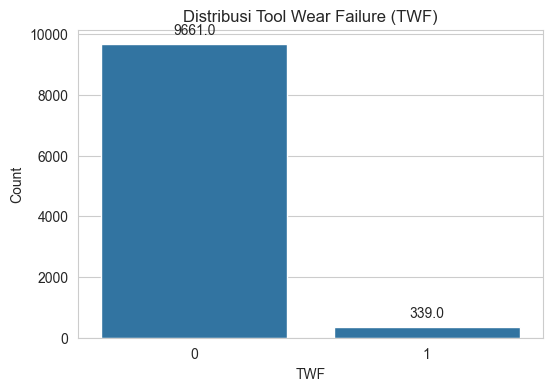

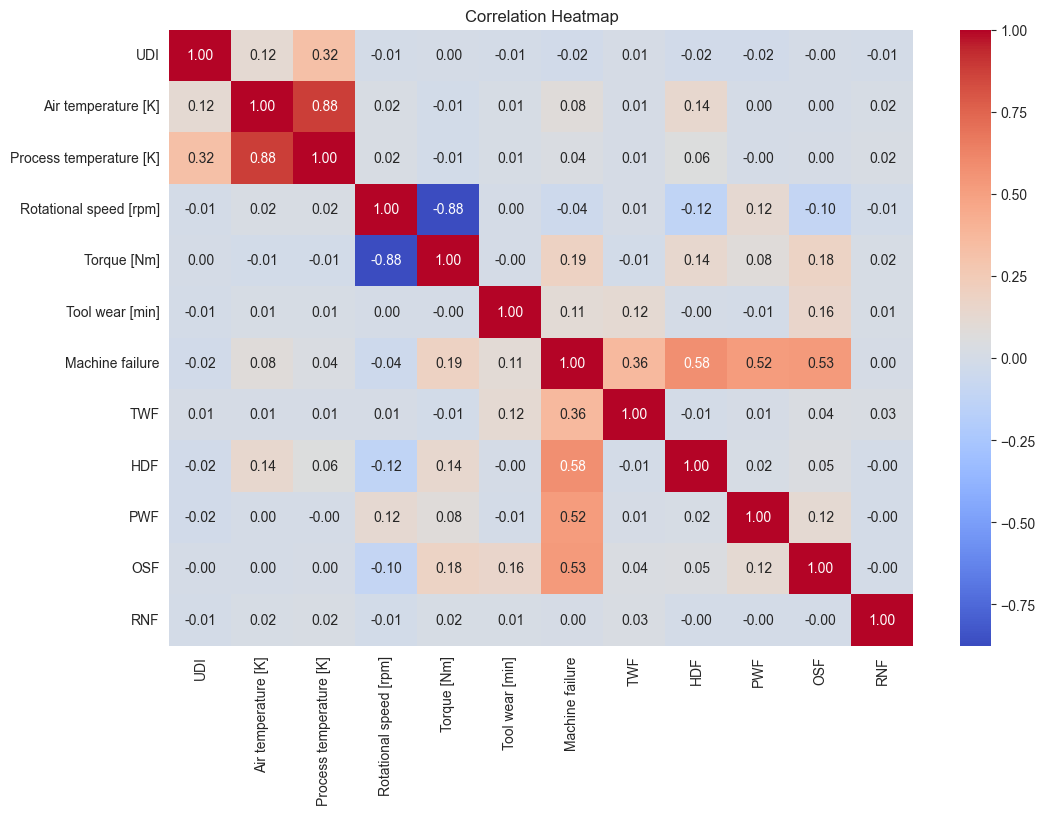

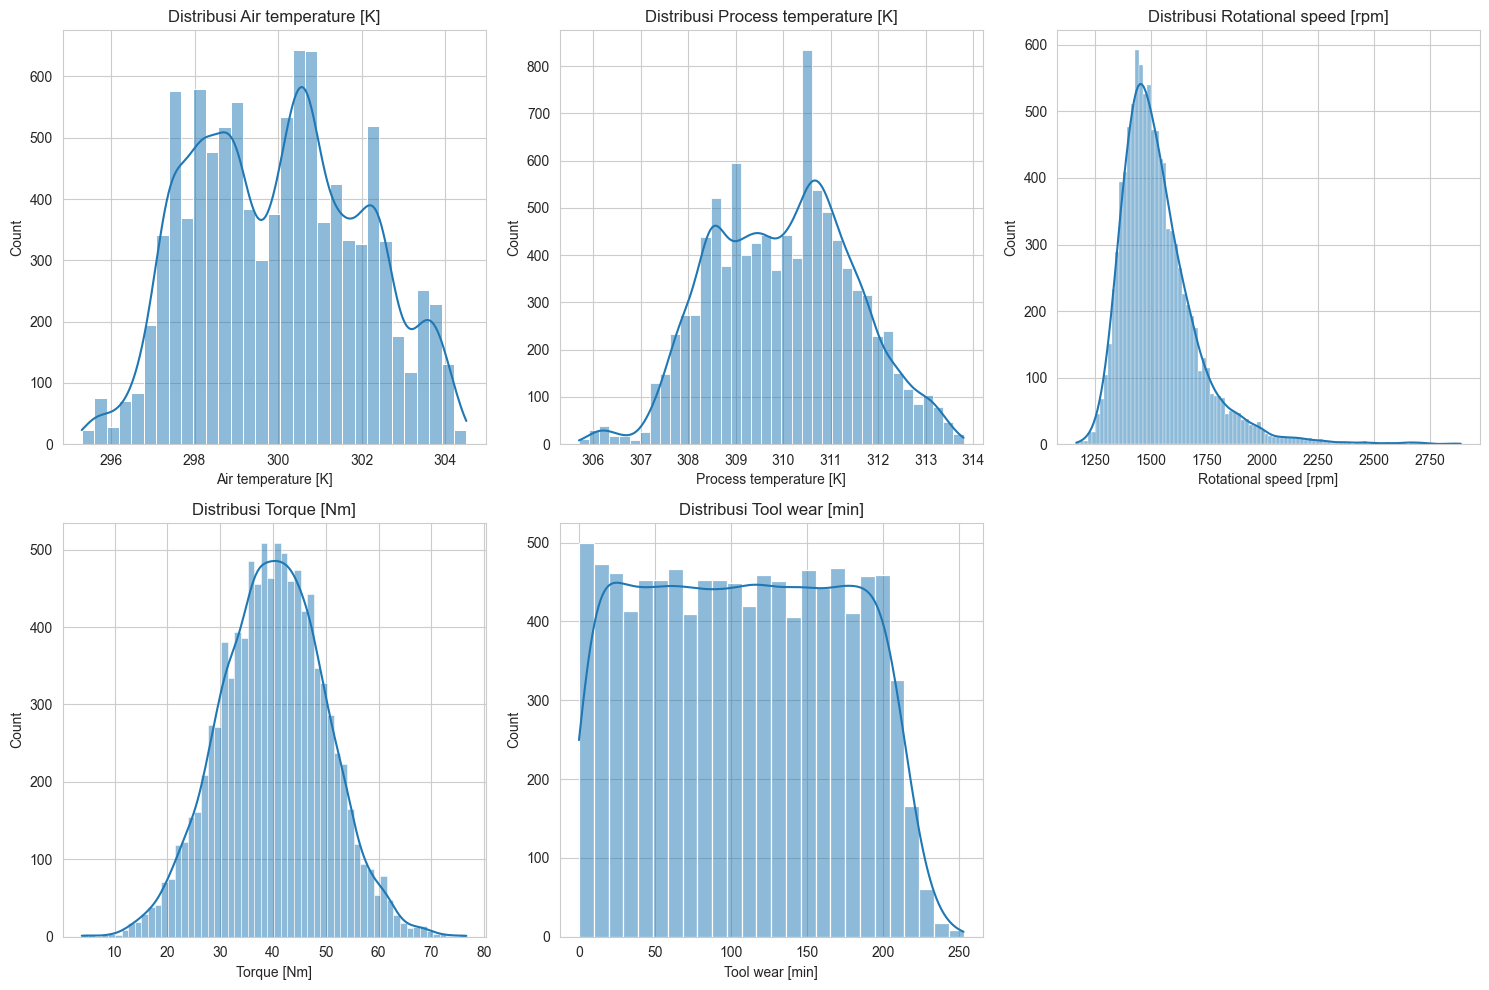

In [4]:
sns.set_style("whitegrid")

plt.figure(figsize=(6,4))
ax = sns.countplot(x='Machine failure', data=data)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.title('Distribusi Tool Wear Failure (TWF)')
plt.xlabel('Machine Failure')
plt.ylabel('Count')
plt.show()

numeric_data = data.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(12,8))
corr_matrix = numeric_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

numerical_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

plt.figure(figsize=(15,10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribusi {feature}')

plt.tight_layout()
plt.show()


In [5]:
data['Temp_Diff'] = data['Process temperature [K]'] - data['Air temperature [K]']
data['Wear_Rate'] = data['Torque [Nm]'] / (data['Rotational speed [rpm]'] + 1)  # +1 to avoid division by zero

data = data.drop(columns=['UDI', 'Product ID'])

X = data.drop(columns=['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])
y = data['Machine failure']

categorical_cols = ['Type']
numerical_cols = X.columns.difference(categorical_cols)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

X_transformed = pipeline.fit_transform(X)

encoded_cat_cols = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols)
feature_names = numerical_cols.tolist() + encoded_cat_cols.tolist()

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Logistic Regression

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


C:\Users\ahmad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
675 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ahmad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ahmad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-p

Best Parameters:  {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy:  0.862
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92      1932
           1       0.18      0.87      0.30        68

    accuracy                           0.86      2000
   macro avg       0.59      0.86      0.61      2000
weighted avg       0.97      0.86      0.90      2000

Confusion Matrix:
 [[1665  267]
 [   9   59]]
ROC AUC Score: 0.935216477895506


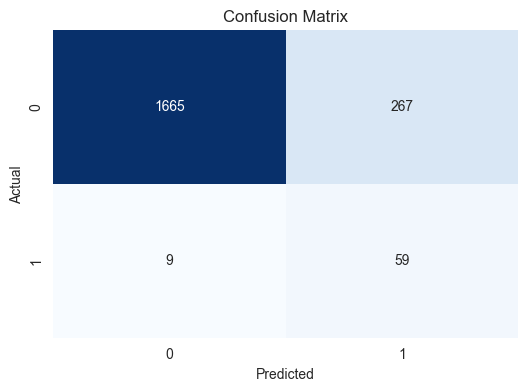

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300]
}

log_reg = LogisticRegression(random_state=42)

grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

grid_search.fit(X_train_res, y_train_res)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Parameters: ", best_params)

y_pred = best_estimator.predict(X_test)
y_pred_proba = best_estimator.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Accuracy: ", acc)
print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)
print("ROC AUC Score:", roc_auc)

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Random Forest Classifier

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters:  {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Random Forest Accuracy:  0.978
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      1932
           1       0.65      0.78      0.71        68

    accuracy                           0.98      2000
   macro avg       0.82      0.88      0.85      2000
weighted avg       0.98      0.98      0.98      2000

Random Forest Confusion Matrix:
 [[1903   29]
 [  15   53]]
Random Forest ROC AUC Score: 0.9718974546340277


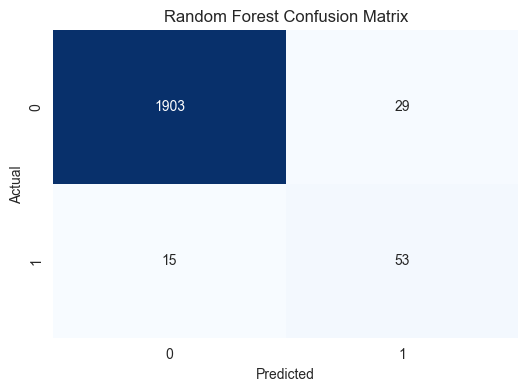

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train_res, y_train_res)

best_params_rf = grid_search_rf.best_params_
best_estimator_rf = grid_search_rf.best_estimator_

print("Best Parameters: ", best_params_rf)

y_pred_rf = best_estimator_rf.predict(X_test)
y_pred_proba_rf = best_estimator_rf.predict_proba(X_test)[:, 1]

acc_rf = accuracy_score(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print("Random Forest Accuracy: ", acc_rf)
print("Random Forest Classification Report:\n", classification_rep_rf)
print("Random Forest Confusion Matrix:\n", conf_matrix_rf)
print("Random Forest ROC AUC Score:", roc_auc_rf)

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Gradient Boosting Classifier (Model Dengan Akurasi Terbaik #1)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters:  {'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 300}
Gradient Boosting Accuracy:  0.9825
Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1932
           1       0.73      0.76      0.75        68

    accuracy                           0.98      2000
   macro avg       0.86      0.88      0.87      2000
weighted avg       0.98      0.98      0.98      2000

Gradient Boosting Confusion Matrix:
 [[1913   19]
 [  16   52]]
Gradient Boosting ROC AUC Score: 0.9617586164900743


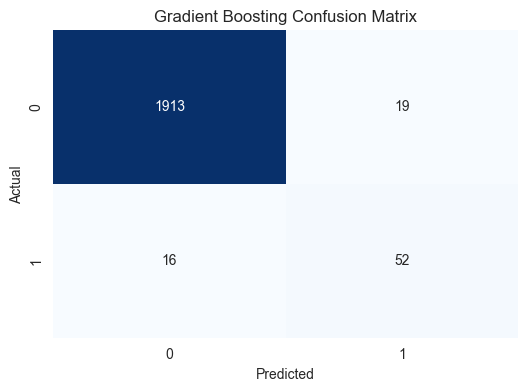

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9]
}

gb = GradientBoostingClassifier(random_state=42)
grid_search_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_gb.fit(X_train_res, y_train_res)

best_params_gb = grid_search_gb.best_params_
best_estimator_gb = grid_search_gb.best_estimator_

print("Best Parameters: ", best_params_gb)

y_pred_gb = best_estimator_gb.predict(X_test)
y_pred_proba_gb = best_estimator_gb.predict_proba(X_test)[:, 1]

acc_gb = accuracy_score(y_test, y_pred_gb)
classification_rep_gb = classification_report(y_test, y_pred_gb)
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb)

print("Gradient Boosting Accuracy: ", acc_gb)
print("Gradient Boosting Classification Report:\n", classification_rep_gb)
print("Gradient Boosting Confusion Matrix:\n", conf_matrix_gb)
print("Gradient Boosting ROC AUC Score:", roc_auc_gb)

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix_gb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Gradient Boosting Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


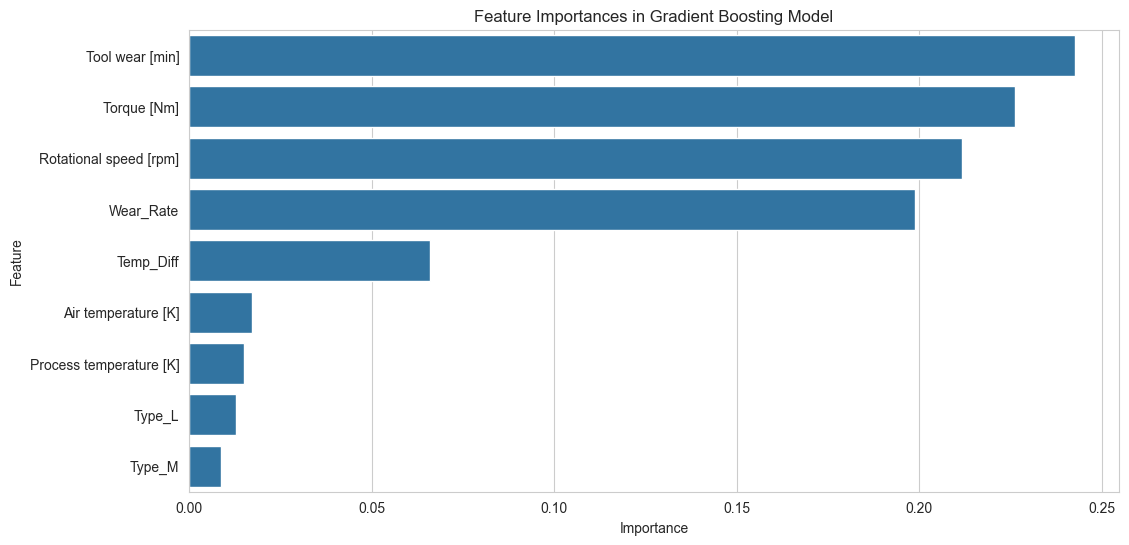

Detail Feature Importances:
                   Feature  Importance
4          Tool wear [min]    0.242643
5              Torque [Nm]    0.226251
2   Rotational speed [rpm]    0.211850
6                Wear_Rate    0.198885
3                Temp_Diff    0.066147
0      Air temperature [K]    0.017259
1  Process temperature [K]    0.015116
7                   Type_L    0.012954
8                   Type_M    0.008895


In [19]:
importances = best_estimator_gb.feature_importances_

feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot barplot
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances in Gradient Boosting Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Menampilkan nilai detail
print("Detail Feature Importances:")
print(feature_importances)

---

### Kesimpulan Evaluasi Model

Dari tiga model yang dievaluasi (Logistic Regression, Random Forest Classifier, dan Gradient Boosting Classifier), **Gradient Boosting Classifier** menunjukkan performa yang paling baik dalam memprediksi kelas target. Model ini mencapai akurasi tinggi secara keseluruhan (0.9825), dengan nilai ROC AUC Score mencapai 0.9617, menandakan kemampuannya yang sangat baik dalam membedakan antara kelas positif dan negatif. Dengan demikian, untuk pemodelan lebih lanjut, disarankan untuk menggunakan Gradient Boosting Classifier sebagai model utama.

### Detail Evaluasi Model

- **Logistic Regression**:
  - Accuracy: 0.862
  - ROC AUC Score: 0.9352

- **Random Forest Classifier**:
  - Accuracy: 0.978
  - ROC AUC Score: 0.9718974546340277

- **Gradient Boosting Classifier**:
  - Accuracy: 0.9825
  - ROC AUC Score: 0.9617